# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lalonde NSWF Dataset

I will use the Lalonde job training dataset for this exercise. This is a very common causal inference example that studied the effects of job trainings on employees' earnings.
> This is a subsample of the data from the treated group in the National Supported Work Demonstration (NSW) and the comparison sample from the Population Survey of Income Dynamics (PSID). This data was previously analyzed extensively by Lalonde (1986) and Dehejia and Wahba (1999). 
https://vincentarelbundock.github.io/Rdatasets/doc/MatchIt/lalonde.html

A data frame with 614 observations (185 treated, 429 control). There are 9 variables measured for each individual.

* "treat" is the treatment assignment (1=treated, 0=control).
* "age" is age in years.
* "educ" is education in number of years of schooling.
* "race" is the individual's race/ethnicity, (Black, Hispanic, or White). Note previous versions of this dataset used indicator variables black and hispan instead of a single race variable.
* "married" is an indicator for married (1=married, 0=not married).
* "nodegree" is an indicator for whether the individual has a high school degree (1=no degree, 0=degree).
* "re74" is income in 1974, in U.S. dollars.
* "re75" is income in 1975, in U.S. dollars.
* "re78" is income in 1978, in U.S. dollars.

# EDA

In [15]:
df = pd.read_csv('Data/lalonde.csv')
df.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  614 non-null    object 
 1   treat     614 non-null    int64  
 2   age       614 non-null    int64  
 3   educ      614 non-null    int64  
 4   race      614 non-null    object 
 5   married   614 non-null    int64  
 6   nodegree  614 non-null    int64  
 7   re74      614 non-null    float64
 8   re75      614 non-null    float64
 9   re78      614 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 48.1+ KB


In [17]:
df['race'].value_counts()

race
white     299
black     243
hispan     72
Name: count, dtype: int64

In [18]:
# compare means and check for imbalances
df = df.drop(columns=['rownames'])
df_encoded = pd.get_dummies(df, columns=['race'], prefix='race')
var_cols = [col for col in df_encoded.columns if col not in ['rownames', 'treat']]
print(var_cols)
# treated and control
mean_compare = df_encoded.groupby('treat')[var_cols].mean().T
mean_compare['diff'] = mean_compare[1] - mean_compare[0]

# using standardized mean difference since dataset is small
std_devs = df_encoded.groupby('treat')[var_cols].std().T
mean_compare['smd'] = mean_compare['diff'] / np.sqrt((std_devs[0]**2 + std_devs[1]**2) / 2)

print("\n")
print(mean_compare)

['age', 'educ', 'married', 'nodegree', 're74', 're75', 're78', 'race_black', 'race_hispan', 'race_white']


treat                  0            1         diff       smd
age            28.030303    25.816216    -2.214087 -0.241904
educ           10.235431    10.345946     0.110515  0.044755
married         0.512821     0.189189    -0.323631 -0.719492
nodegree        0.596737     0.708108     0.111372  0.235048
re74         5619.236506  2095.573689 -3523.662818 -0.595752
re75         2466.484443  1532.055314  -934.429129 -0.287002
re78         6984.169742  6349.143530  -635.026212 -0.083708
race_black      0.202797     0.843243     0.640446  1.667719
race_hispan     0.142191     0.059459    -0.082732 -0.276940
race_white      0.655012     0.097297    -0.557714 -1.405738


* The treated group leans younger and unmarried, with likely no highschool degree. 
* There is also a heavy imbalance between the races, with control leaning more white and treated leaning more black
* While the mean 1974 earnings of the treated group were much lower than control, they become comparable in 1978
* The NSW program was targeted to the marginalized groups that represent the treated group, but it does present some selection bias for this experiment

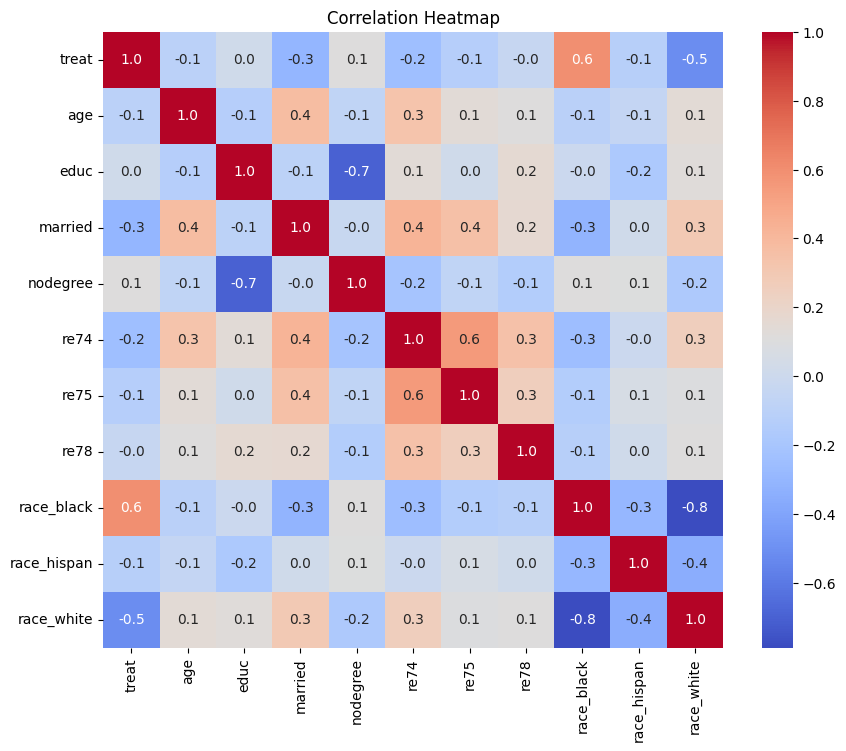

In [20]:
# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

In [21]:
corr

,treat,age,educ,married,nodegree,re74,re75,re78,race_black,race_hispan,race_white
treat,1.000000,-0.102893,0.019308,-0.301334,0.105857,-0.249779,-0.130197,-0.039033,0.600907,-0.117983,-0.511959
age,-0.102893,1.000000,-0.125622,0.376059,-0.069218,0.333254,0.140022,0.106249,-0.110730,-0.053400,0.142707
educ,0.019308,-0.125622,1.000000,-0.095051,-0.701452,0.136583,0.018301,0.161538,-0.010528,-0.174153,0.122400
married,-0.301334,0.376059,-0.095051,1.000000,-0.032349,0.425739,0.353824,0.162358,-0.317118,0.021549,0.296385
nodegree,0.105857,-0.069218,-0.701452,-0.032349,1.000000,-0.208751,-0.070412,-0.142418,0.109278,0.100869,-0.171841
re74,-0.249779,0.333254,0.136583,0.425739,-0.208751,1.000000,0.552002,0.343416,-0.257334,-0.007091,0.256330
re75,-0.130197,0.140022,0.018301,0.353824,-0.070412,0.552002,1.000000,0.257659,-0.140374,0.061589,0.097692
re78,-0.039033,0.106249,0.161538,0.162358,-0.142418,0.343416,0.257659,1.000000,-0.120977,0.015325,0.108494
race_black,0.600907,-0.110730,-0.010528,-0.317118,0.109278,-0.257334,-0.140374,-0.120977,1.000000,-0.294973,-0.788491
race_hispan,-0.117983,-0.053400,-0.174153,0.021549,0.100869,-0.007091,0.061589,0.015325,-0.294973,1.000000,-0.355097


Some of these correlations are obvisous like age and education length or married. But we do see a strong score with treatment and the races, affirming the selection bias here.

# Results / Discussion

# References / Inspiration

* https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f/
* Lalonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. American Economic Review 76: 604-620.
* Dehejia, R.H. and Wahba, S. (1999). Causal Effects in Nonexperimental Studies: Re-Evaluating the Evaluation of Training Programs. Journal of the American Statistical Association 94: 1053-1062.